# KBO 데이터 크롤링

### 모듈 선언 및 URL 경로 지정

In [8]:
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
from selenium import webdriver
import time
import pandas as pd
import numpy as np
from tqdm import tqdm

url_base = 'https://www.koreabaseball.com/Record/Team/{category}'
category_list = ['Hitter/Basic1.aspx', 'Hitter/Basic2.aspx', 'Pitcher/Basic1.aspx', 'Pitcher/Basic2.aspx',
                 'Defense/Basic.aspx', 'Runner/Basic.aspx']
category_name_list = ['Hitter_1', 'Hitter_2', 'Pitcher_1', 'Pitcher_2', 'Defense', 'Runner']

driver = webdriver.Chrome('C:/chrome_driver/87/chromedriver.exe')
driver.implicitly_wait(3)

### 연도 클릭 함수 선언

In [10]:
def year_click(year):
    driver.find_element_by_class_name('select03').click()
    xpath_format = '//option[@value="{year}"]'
    driver.find_element_by_xpath(xpath_format.format(year=year)).click()

### KBO 전체 데이터 크롤링

In [11]:
for category in category_list:
    url = url_base.format(category = category) # 타자, 투수, 수비, 주루 데이터 선택
    driver.get(url)
    
    year_list = [x.strip() for x in driver.find_element_by_class_name('select03').text.split('\n') if len(x)>1] # 연도 리스트 추출
    
    for year in year_list:
        year_click(str(year)) # 각 연도 클릭
        time.sleep(0.2) # 대기
        
        temp_list = [x.split(' ') for x in driver.find_element_by_tag_name('table').text.split('\n')] # 데이터리스트 생성
                
        for i in range(len(temp_list)):
            for j in range(len(temp_list[i])):
                if '합계'==str(temp_list[i][j]): # 마지막 행 삭제
                    temp_list.pop(i)
                    break
                if '/' in str(temp_list[i][j]): # 이닝 표기문제 해결
                    temp_list[i].pop(j)
                    break
                
        temp_data = pd.DataFrame(temp_list[1:], columns=temp_list[0]) # 데이터리스트 --> 데이터프레임
        temp_data.to_csv('1. Original Datasets/'+str(year)+'_'+str(category_name_list[category_list.index(category)])+'_data.csv',
                         index=False, encoding='cp949') # 데이터프레임 저장
        
driver.close()

# 데이터 합치기

### 팀 이름으로 정렬하기

In [12]:
import pandas as pd

In [13]:
year_list = [x for x in range(2001, 2021)]
data_list = ['Defense', 'Hitter_1', 'Hitter_2', 'Pitcher_1', 'Pitcher_2', 'Runner']

In [14]:
DataFrame_list = []
DataFrame_namelist = []
for year in year_list:
    for data in data_list:
        globals()['DATA_'+str(year)+'_'+data] = pd.read_csv('1. Original Datasets/'+str(year)+'_'+data+'_data.csv', encoding='cp949')
        DataFrame_list.append(pd.read_csv('1. Original Datasets/'+str(year)+'_'+data+'_data.csv', encoding='cp949'))
        DataFrame_namelist.append('DATA_'+str(year)+'_'+data)

In [15]:
DataFrame_namelist

['DATA_2001_Defense',
 'DATA_2001_Hitter_1',
 'DATA_2001_Hitter_2',
 'DATA_2001_Pitcher_1',
 'DATA_2001_Pitcher_2',
 'DATA_2001_Runner',
 'DATA_2002_Defense',
 'DATA_2002_Hitter_1',
 'DATA_2002_Hitter_2',
 'DATA_2002_Pitcher_1',
 'DATA_2002_Pitcher_2',
 'DATA_2002_Runner',
 'DATA_2003_Defense',
 'DATA_2003_Hitter_1',
 'DATA_2003_Hitter_2',
 'DATA_2003_Pitcher_1',
 'DATA_2003_Pitcher_2',
 'DATA_2003_Runner',
 'DATA_2004_Defense',
 'DATA_2004_Hitter_1',
 'DATA_2004_Hitter_2',
 'DATA_2004_Pitcher_1',
 'DATA_2004_Pitcher_2',
 'DATA_2004_Runner',
 'DATA_2005_Defense',
 'DATA_2005_Hitter_1',
 'DATA_2005_Hitter_2',
 'DATA_2005_Pitcher_1',
 'DATA_2005_Pitcher_2',
 'DATA_2005_Runner',
 'DATA_2006_Defense',
 'DATA_2006_Hitter_1',
 'DATA_2006_Hitter_2',
 'DATA_2006_Pitcher_1',
 'DATA_2006_Pitcher_2',
 'DATA_2006_Runner',
 'DATA_2007_Defense',
 'DATA_2007_Hitter_1',
 'DATA_2007_Hitter_2',
 'DATA_2007_Pitcher_1',
 'DATA_2007_Pitcher_2',
 'DATA_2007_Runner',
 'DATA_2008_Defense',
 'DATA_2008_Hitter_

In [16]:
for idx in range(len(DataFrame_list)):
    temp = DataFrame_list[idx].sort_values(by=['팀명'], ascending=True)
    temp.to_csv('2. Sorted Datasets/'+str(DataFrame_namelist[idx])+'.csv', encoding='cp949', index=False)

### 연도별로 전체 데이터 합치기

In [10]:
year_list = [x for x in range(2001, 2021)]
data_list = ['Defense', 'Hitter_1', 'Hitter_2', 'Pitcher_1', 'Pitcher_2', 'Runner']

In [11]:
for year in year_list:   
    df = pd.DataFrame()
    
    for data in data_list:
        df = pd.concat([df, pd.read_csv('2. Sorted Datasets/DATA_'+str(year)+'_'+data+'.csv', encoding='cp949')], axis=1)
        
    del df['순위']
    df.to_csv('3. Combined Datasets/DATA_'+str(year)+'.csv', encoding='cp949', index=False)

### 빅데이터 만들기

In [12]:
df = pd.DataFrame()

for year in year_list:      
    df = pd.concat([df, pd.read_csv('3. Combined Datasets/DATA_'+str(year)+'.csv', encoding='cp949')], axis=0)

# 중복 열 제거
df = df.T.drop_duplicates().T 

# W를 가장 오른쪽에 배치
W_list = df['W'] 
del df['W']
df['W'] = W_list

# index 리셋
df = df.reset_index(drop=True)

# 팀명 한글 --> 코드 변환
for i in range(len(df)):
    if df['팀명'][i]=='두산':
        df['팀명'][i]='OB'
    elif df['팀명'][i]=='키움' or df['팀명'][i]=='넥센' or df['팀명'][i]=='히어로즈' or df['팀명'][i]=='우리':
        df['팀명'][i]='WO'
    elif df['팀명'][i]=='KIA':
        df['팀명'][i]='HT'
    elif df['팀명'][i]=='삼성':
        df['팀명'][i]='SS'
    elif df['팀명'][i]=='롯데':
        df['팀명'][i]='LT'
    elif df['팀명'][i]=='한화':
        df['팀명'][i]='HH'
    elif df['팀명'][i]=='현대':
        df['팀명'][i]='HD'

# 빅데이터 저장
df.to_csv('4. BIGDATA/TOTAL_DATA.csv', encoding='cp949', index=False)

# 탐색적 데이터 분석

### 데이터 한눈에 보기

In [13]:
import pandas as pd
df = pd.read_csv('4. BIGDATA/TOTAL_DATA.csv', encoding='cp949"')
df.head()

,팀명,G,E,PKO,PO,A,DP,FPCT,PB,SB,...,IBB.1,WP,BK,SBA,SB.1,CS.1,SB%,OOB,PKO.1,W
0,HT,133,107,1,3536,1477,134,0.979,10,100,...,17,51,3,155,92,63,59.4,0,0,60
1,LG,133,103,12,3554,1485,129,0.980,16,110,...,43,52,6,154,96,58,62.3,0,0,58
2,SK,133,96,3,3514,1434,124,0.981,19,106,...,31,54,1,182,123,59,67.6,0,0,60
3,OB,133,109,3,3541,1599,140,0.979,12,126,...,17,47,0,166,132,34,79.5,0,0,65
4,LT,133,99,9,3515,1518,141,0.981,12,85,...,23,53,2,159,106,53,66.7,0,0,59


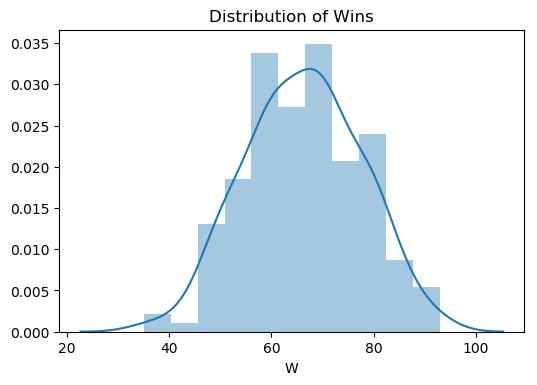

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(dpi=100)
plt.xlabel('Wins')
plt.title('Distribution of Wins')
sns.distplot(df['W'], norm_hist=True)
plt.show()

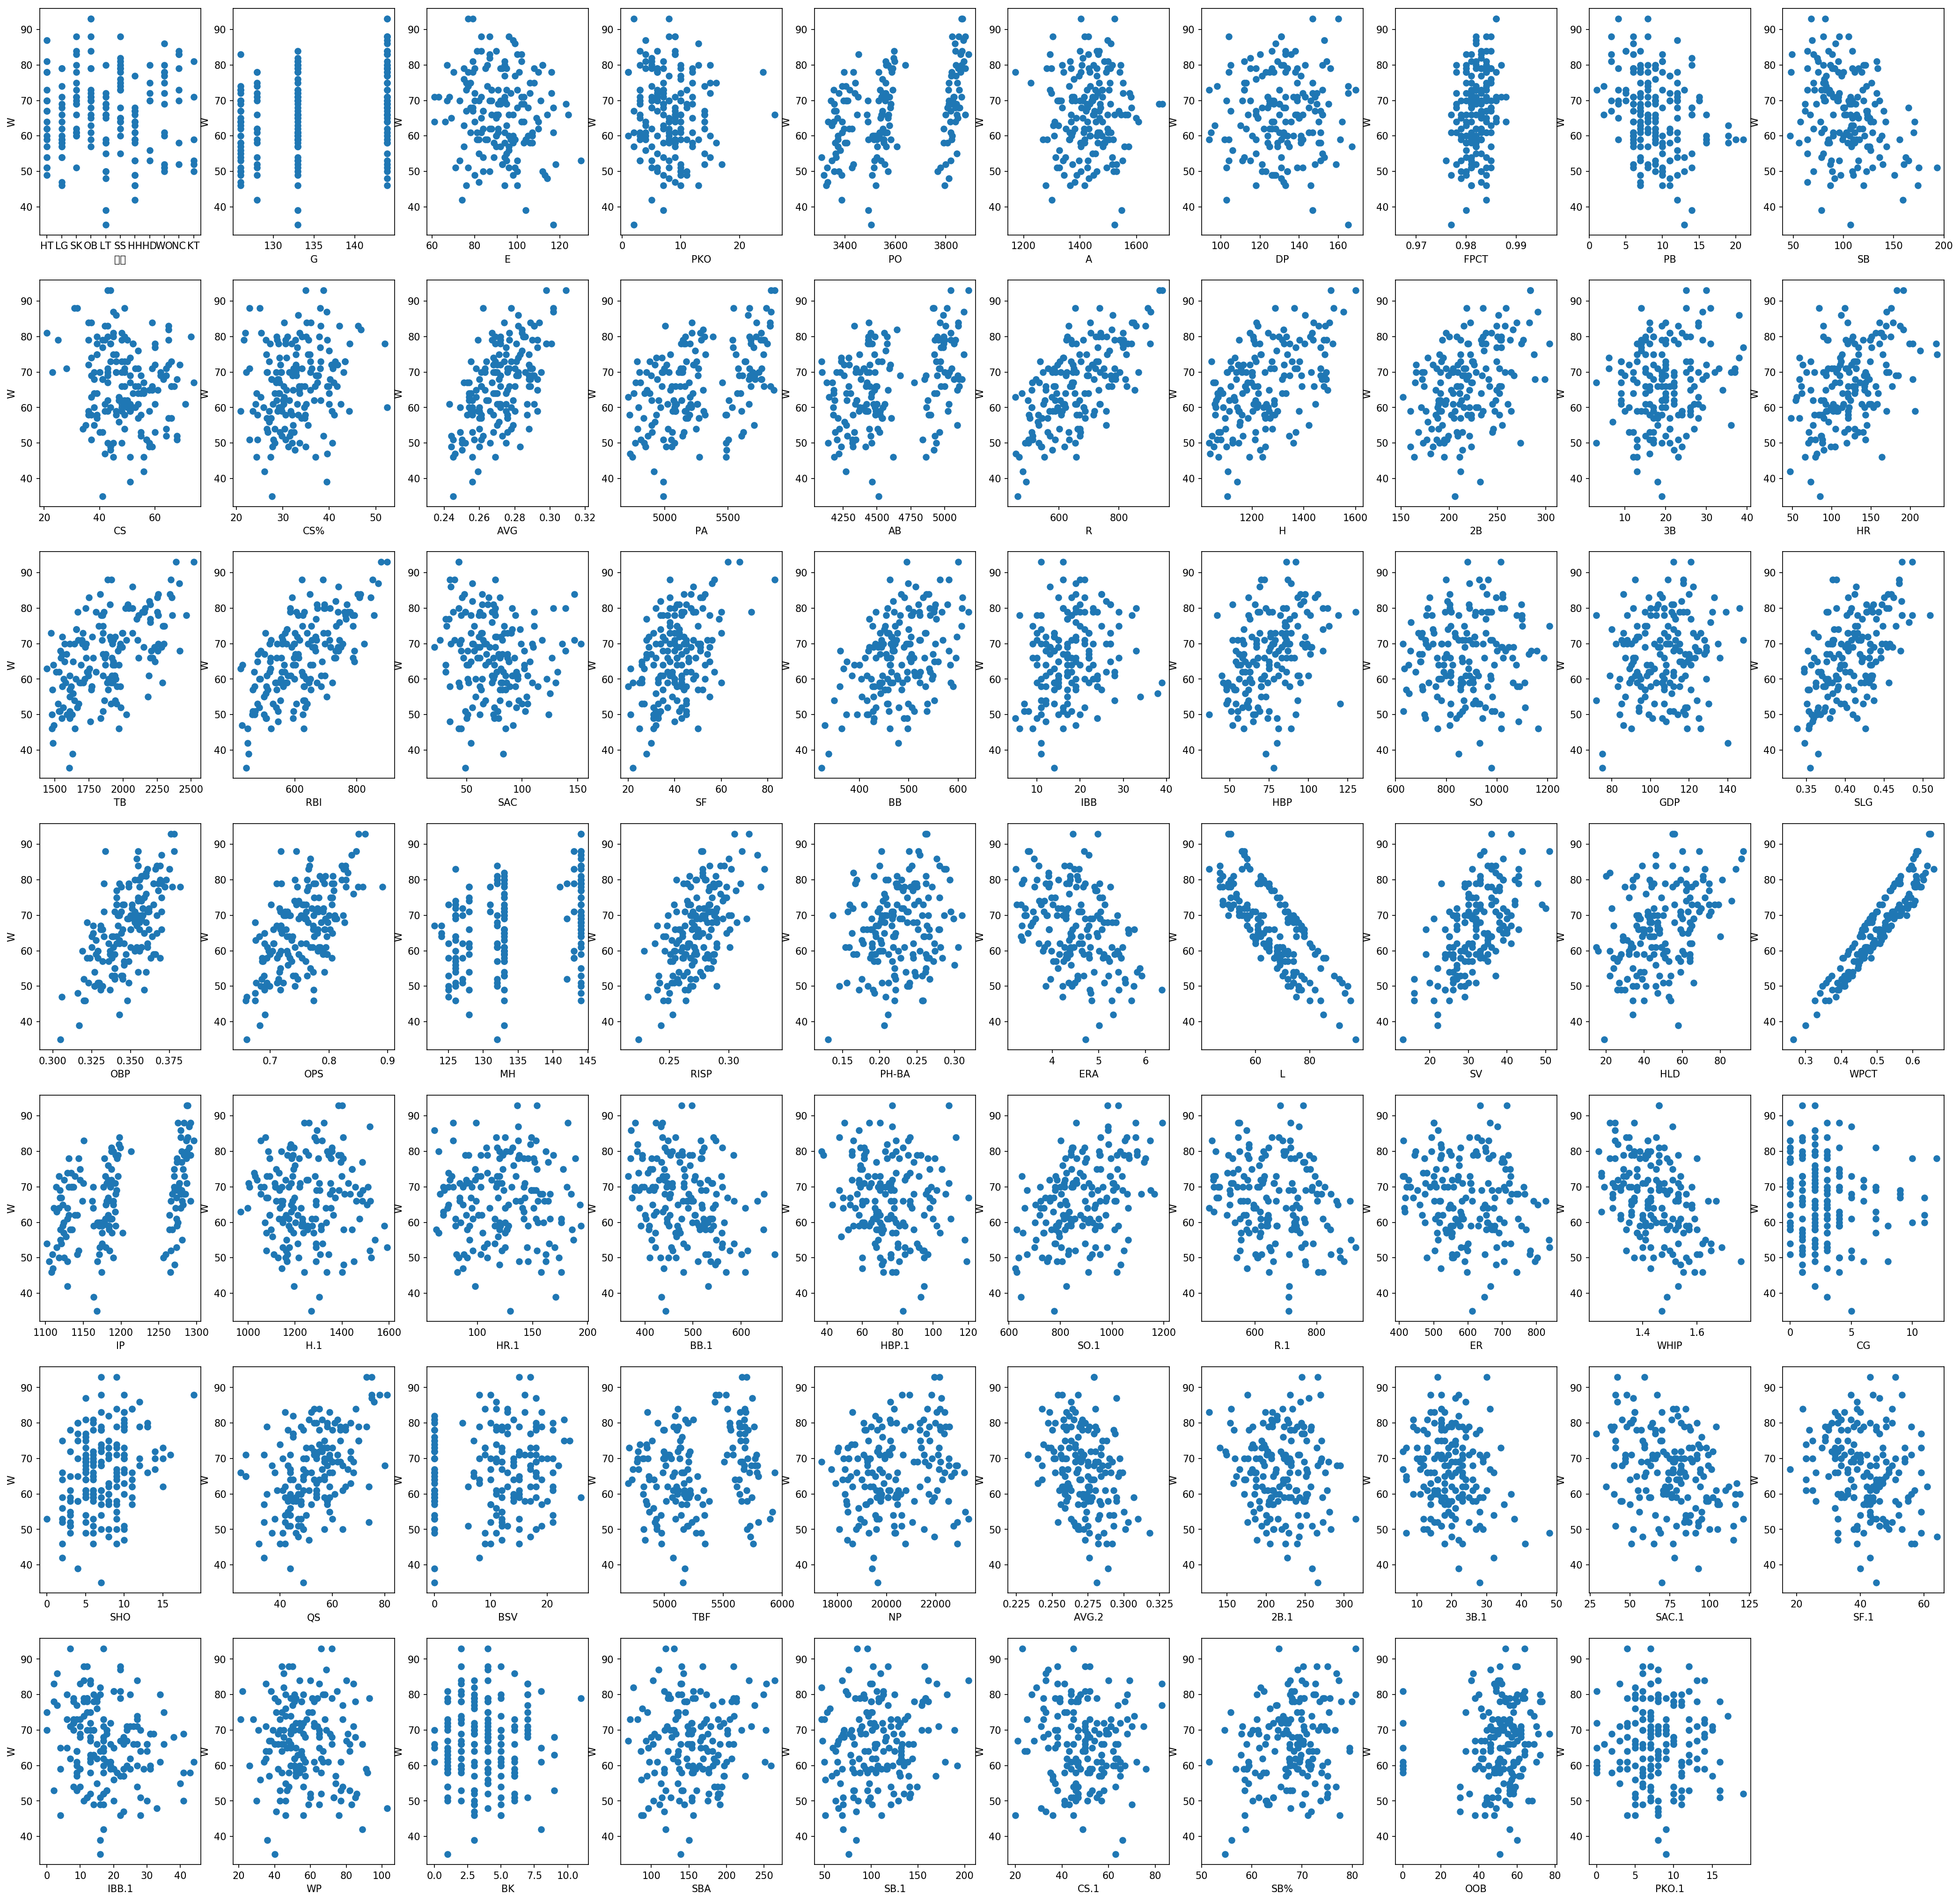

In [15]:
count=1
plt.figure(figsize=(35,35), dpi=150)
for item in list(df.columns):
    if item!='W':
        plt.subplot(7, 10, count)
        plt.xlabel(item)
        plt.ylabel('W')
        plt.scatter(df[item], df['W'])
    count += 1

### Drop 요소 선택

In [16]:
# Win 수와 너무 직접적인 Lose 수나 승률 등의 요소 및 관련 별로 없는 지표들 Drop
drop_list = ['팀명', 'G', 'E', 'PKO', 'DP', 'FPCT', 'PB', 'SB', 'CS', 'CS%', 'SAC', 'SO', 'GDP', 'MH', 'PH-BA', 'L',
             'WPCT', 'IP', 'H.1', 'HR.1', 'BB.1', 'HBP.1', 'R.1', 'ER', 'CG', 'SHO', 'BSV', '2B.1', '3B.1', 'SAC.1',
             'SF.1', 'IBB.1', 'WP', 'BK', 'PKO.1']
df = df.drop(drop_list, axis=1)
df.head()

,PO,A,AVG,PA,AB,R,H,2B,3B,HR,...,QS,TBF,NP,AVG.2,SBA,SB.1,CS.1,SB%,OOB,W
0,3536,1477,0.278,5189,4542,683,1263,221,17,142,...,35,5207,19799,0.272,155,92,63,59.4,0,60
1,3554,1485,0.276,5319,4521,669,1247,219,24,85,...,43,5380,21119,0.277,154,96,58,62.3,0,58
2,3514,1434,0.260,5077,4400,596,1143,215,11,113,...,61,5110,19710,0.259,182,123,59,67.6,0,60
3,3541,1599,0.276,5303,4583,732,1266,221,26,130,...,27,5282,20071,0.284,166,132,34,79.5,0,65
4,3515,1518,0.280,5308,4521,718,1265,247,24,121,...,43,5189,19593,0.276,159,106,53,66.7,0,59


# Training

### Decision Tree Regression

In [17]:
import pandas as pd

In [18]:
df = pd.read_csv('4. BIGDATA/TOTAL_DATA.csv', encoding='cp949"')
df = df.drop(drop_list, axis=1)
x_data = df.values[:, 0:len(df.columns)-1]
y_data = df.values[:, [len(df.columns)-1]]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, shuffle=True)

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=100, max_depth=100, max_leaf_nodes=None, max_features=30, learning_rate=0.001)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

C:\Users\nakhe\Anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\nakhe\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.111


In [21]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [500, 750, 1000],
           'max_depth' : [10, 50, 75, 100],
           'max_features' : [5, 15, 30]
         }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = GradientBoostingClassifier()
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

C:\Users\nakhe\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


최적 하이퍼 파라미터:  {'max_depth': 10, 'max_features': 30, 'n_estimators': 500}
최고 예측 정확도: 0.0680


In [24]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
from sklearn.metrics import accuracy_score
rf_clf1 = GradientBoostingClassifier(n_estimators = 100, 
                                     max_depth = 12,
                                     min_samples_leaf = 8,
                                     min_samples_split = 8,
                                     random_state = 0,
                                     )
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,pred)))

C:\Users\nakhe\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


예측 정확도: 0.1481


### 1st Linear Regression

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv('4. BIGDATA/TOTAL_DATA.csv', encoding='cp949"')
df = df.drop(drop_list, axis=1)
x_data = df.values[:, 0:len(df.columns)-1]
y_data = df.values[:, [len(df.columns)-1]]

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

In [27]:
poly_features = PolynomialFeatures(degree=1, include_bias=False)
x_data = poly_features.fit_transform(x_data)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, shuffle=True)
lr = LinearRegression().fit(X_train, y_train)
print("훈련 정확도:{:.5f}".format(lr.score(X_train, y_train)))
print("테스트 정확도:{:.5f}".format(lr.score(X_test, y_test)))

훈련 정확도:0.95451
테스트 정확도:0.91216


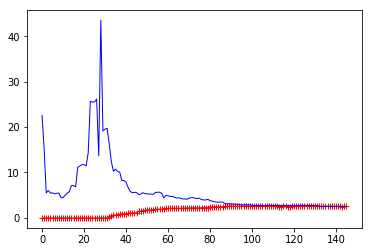

In [28]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="훈련세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label='검증세트')

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=1, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, x_data, y_data)

In [29]:
y_predict = lr.predict(X_test)

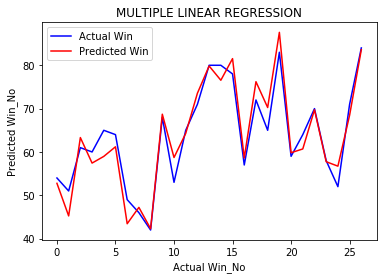

In [30]:
import matplotlib.pyplot as plt

plt.plot(y_test, color='b')
plt.plot(y_predict, color='r')
plt.xlabel("Actual Win_No")
plt.ylabel("Predicted Win_No")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.legend(['Actual Win', 'Predicted Win'])
plt.show()

### 2nd Linear Regression

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

df = pd.read_csv('4. BIGDATA/TOTAL_DATA.csv', encoding='cp949"')
df = df.drop(drop_list, axis=1)
x_data = df.values[:, 0:len(df.columns)-1]
y_data = df.values[:, [len(df.columns)-1]]

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

In [33]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_data = poly_features.fit_transform(x_data)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, shuffle=True)
lr = LinearRegression().fit(X_train, y_train)
print("훈련 정확도:{:.5f}".format(lr.score(X_train, y_train)))
print("테스트 정확도:{:.5f}".format(lr.score(X_test, y_test)))

훈련 정확도:1.00000
테스트 정확도:0.34405


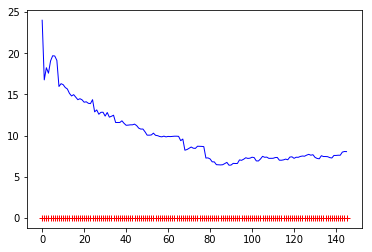

In [34]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="훈련세트")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label='검증세트')

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=1, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, x_data, y_data)

In [35]:
y_predict = lr.predict(X_test)

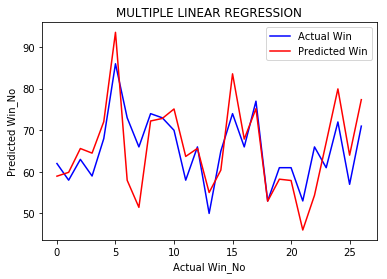

In [36]:
import matplotlib.pyplot as plt

plt.plot(y_test, color='b')
plt.plot(y_predict, color='r')
plt.xlabel("Actual Win_No")
plt.ylabel("Predicted Win_No")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.legend(['Actual Win', 'Predicted Win'])
plt.show()